In [1]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

In [2]:
# Data Extract From Physionet *.dat

input_path = "../ECG_DATASET/mitbih_stch/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
#     if l in ["00735","03665"]:
#         continue
    records_list.append(l)
records.close()
print(records_list)

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327']


In [3]:
#record = wfdb.rdsamp("./ECG_DATASET/mitbih_atrial/files/00735", sampfrom=0, sampto=650000)
#annotation =wfdb.rdann("./ECG_DATASET/mitbih_atrial/files/00735","atr", sampfrom=0, sampto=650000)
idx = -4
record = wfdb.rdrecord("../ECG_DATASET/mitbih_stch/"+records_list[idx])
annotation =wfdb.rdann("../ECG_DATASET/mitbih_stch/"+records_list[idx],"atr")

In [4]:
record.__dict__

{'record_name': '324',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 649224,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG', 'ECG'],
 'p_signal': array([[ 0.31      ,  0.41333333],
        [ 0.32      ,  0.40666667],
        [ 0.33333333,  0.41333333],
        ...,
        [-0.11333333, -0.25333333],
        [-0.12666667, -0.26      ],
        [-0.11333333, -0.25333333]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['324.dat', '324.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [300.0, 300.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [93, 124],
 'checksum': [28745, 25491],
 'block_size': [0, 0]}

In [5]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[0:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[0:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)

    return record_sig, record_ann, record_ann_sym

In [6]:
# idx = 
sampfrom = 0
sampto = record.__dict__["sig_len"]
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto)
print(record_sig)
# print(record_ann)

print("===========================================================================================")
print("abnormal position :",[record_ann[x] for x in np.where(np.array(record_ann_sym) != "N")[0]])

from collections import Counter
print(Counter(record_ann_sym))

(array([[ 0.31      ],
       [ 0.32      ],
       [ 0.33333333],
       ...,
       [-0.11333333],
       [-0.12666667],
       [-0.11333333]]), {'fs': 360, 'sig_len': 649224, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['ECG'], 'comments': []})
abnormal position : [1360, 2695, 4309, 5236, 6486, 7401, 8328, 9932, 10854, 13099, 14481, 15864, 17669, 19079, 20931, 22393, 25023, 26923, 29230, 32395, 35205, 83916, 116966, 125406, 133954, 141239, 144520, 148229, 161143, 163956, 166746, 169104, 171855, 174090, 175567, 177479, 179789, 181623, 183462, 184888, 186629, 187995, 189397, 190832, 192569, 193541, 194926, 196698, 198035, 199362, 200720, 202097, 203463, 204868, 206283, 208141, 209975, 211369, 212752, 214144, 215513, 217652, 219062, 221304, 223179, 224625, 226481, 228327, 230187, 232036, 233864, 234042, 235653, 237534, 239785, 242949, 244783, 244949, 245081, 245249, 246064, 248253, 249644, 251748, 253117, 254821, 256158, 257509, 259373, 262302, 263669

<IPython.core.display.Javascript object>


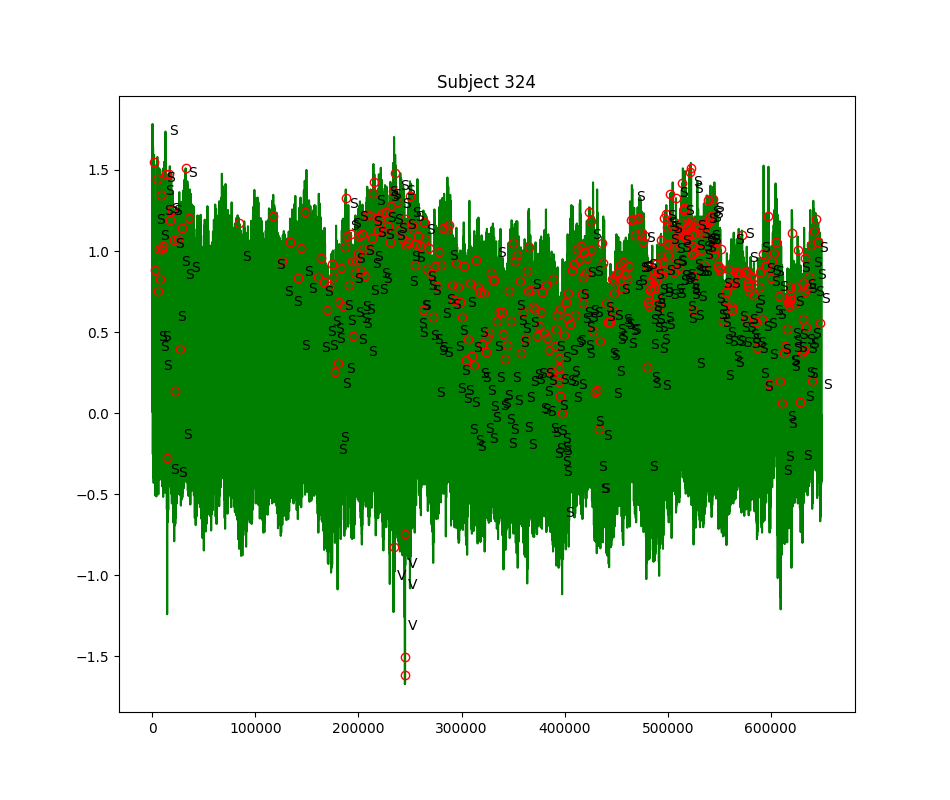

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,8))
ax_ann = fig.add_subplot(1,1,1)
ax_ann.set_title("Subject {}".format(records_list[idx]))
x_data = np.squeeze(np.array(record_sig[0]),axis=1)
ax_ann.plot(x_data,color="green")

for i,x_location in enumerate(record_ann):
    if record_ann_sym[i] == "N":
        continue
    ax_ann.annotate(record_ann_sym[i], xy=(x_location,x_data[x_location-sampfrom]),
                    xycoords="data", textcoords="offset pixels", xytext=(3,17))

record_ann_x = [x_location-sampfrom-1 for i,x_location in enumerate(record_ann) if record_ann_sym[i]!="N"]
record_ann_v = [x_data[x_location-sampfrom-1] for x_location in record_ann_x]
ax_ann.plot(record_ann_x, record_ann_v, "ro", linewidth=2, fillstyle="none")

fig.show()



### ST Segment

In [8]:
from skimage.restoration import denoise_wavelet

In [9]:
x_denoise_sym4 = denoise_wavelet(x_data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="sym4", rescale_sigma="True")
x_denoise_sym8 = denoise_wavelet(x_data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="sym8", rescale_sigma="True")
x_denoise_db16 = denoise_wavelet(x_data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="db16", rescale_sigma="True")
x_denoise_db4 = denoise_wavelet(x_data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="db4", rescale_sigma="True")

<IPython.core.display.Javascript object>


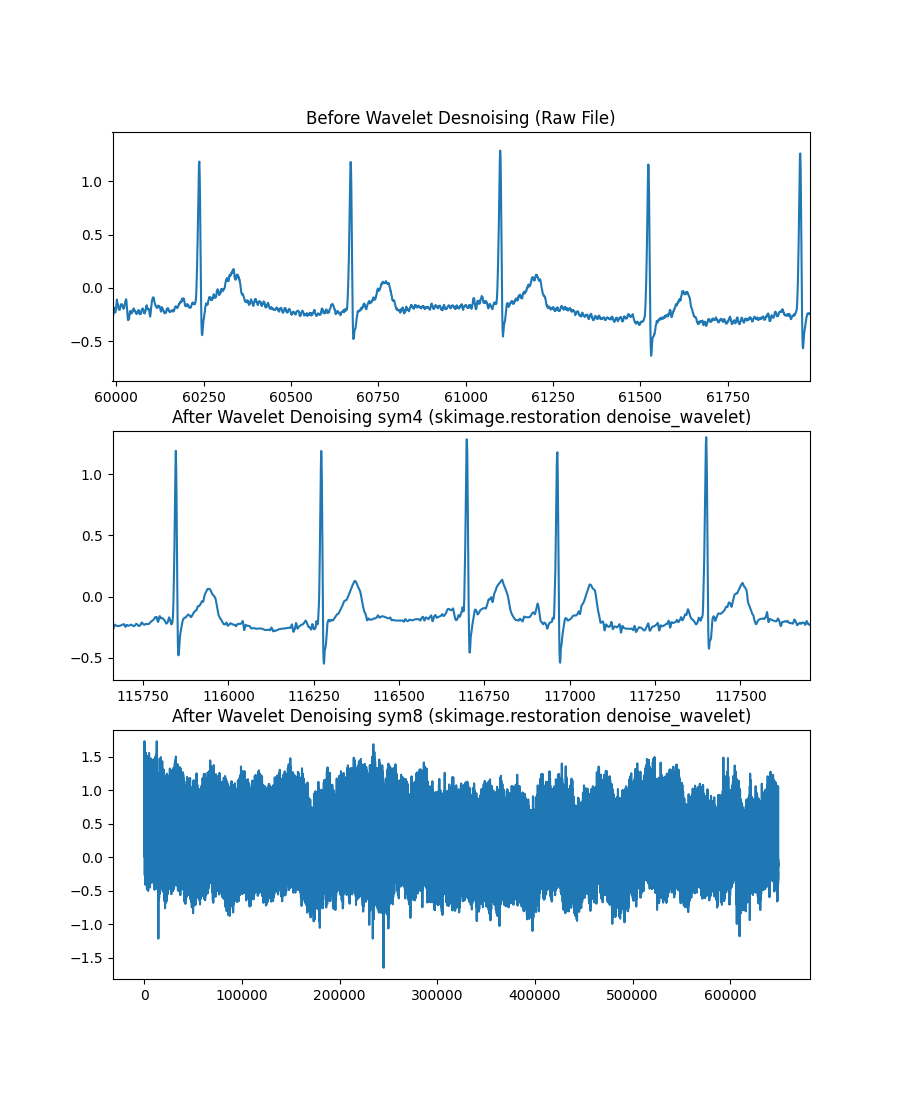

Text(0.5, 1.0, 'After Wavelet Denoising sym8 (skimage.restoration denoise_wavelet)')

In [66]:
%matplotlib notebook
fig = plt.figure(figsize=(9,11))

ax = fig.add_subplot(3,1,1)
# ax.plot(np.arange(record_len), amp)
ax.plot(x_data)
ax.set_title("Before Wavelet Desnoising (Raw File)")

ax2 = fig.add_subplot(3,1,2)
# ax3.plot(np.arange(len(datarec)), datarec)
ax2.plot(x_denoise_sym4)
ax2.set_title("After Wavelet Denoising sym4 (skimage.restoration denoise_wavelet)")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(x_denoise_sym8)
ax3.set_title("After Wavelet Denoising sym8 (skimage.restoration denoise_wavelet)")

# ax4 = fig.add_subplot(5,1,4)
# ax4.plot(np.arange(5000), x_denoise_db16[:5000])
# ax4.set_title("After Wavelet Denoising db16 (skimage.restoration denoise_wavelet)")

# ax5 = fig.add_subplot(5,1,5)
# ax5.plot(np.arange(5000), x_denoise_db4[:5000])
# ax5.set_title("After Wavelet Denoising db4 (skimage.restoration denoise_wavelet)")
# plt.tight_layout()
# plt.show()

위 부분은 ST Depression를 보여주는데.. 너무 말도 안되는 그래프라..

### European ST-T

In [72]:
# Data Extract From Physionet *.dat

input_path = "../ECG_DATASET/eurostt/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
#     if l in ["00735","03665"]:
#         continue
    records_list.append(l)
records.close()
print(records_list)

['e0103', 'e0104', 'e0105', 'e0106', 'e0107', 'e0108', 'e0110', 'e0111', 'e0112', 'e0113', 'e0114', 'e0115', 'e0116', 'e0118', 'e0119', 'e0121', 'e0122', 'e0123', 'e0124', 'e0125', 'e0126', 'e0127', 'e0129', 'e0133', 'e0136', 'e0139', 'e0147', 'e0148', 'e0151', 'e0154', 'e0155', 'e0159', 'e0161', 'e0162', 'e0163', 'e0166', 'e0170', 'e0202', 'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210', 'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305', 'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409', 'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0501', 'e0509', 'e0515', 'e0601', 'e0602', 'e0603', 'e0604', 'e0605', 'e0606', 'e0607', 'e0609', 'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704', 'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304']


In [73]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[0:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[0:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)

    return record_sig, record_ann, record_ann_sym

In [79]:
idx = 3
sampfrom = 0
sampto = record.__dict__["sig_len"]
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto)
print(record_sig)
# print(record_ann)

print("===========================================================================================")
print("abnormal position :",[record_ann[x] for x in np.where(np.array(record_ann_sym) != "N")[0]])

from collections import Counter
print(Counter(record_ann_sym))

(array([[-0.64 ],
       [-0.64 ],
       [-0.635],
       ...,
       [-1.24 ],
       [-1.225],
       [-1.22 ]]), {'fs': 250, 'sig_len': 649224, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['MLIII'], 'comments': ['Age: 56  Sex: M', 'Mixed angina', '2-vessel disease (LAD, LCX)', 'Medications: nitrates, verapamil', 'Recorder type: Oxford Medilog 4-24']})
abnormal position : [106, 114929, 115274, 115473, 116273, 159001, 172471, 174771, 181944, 188563, 190927, 192653, 198104, 208311, 500693, 505819, 525949, 527119, 527311, 533536, 534955, 535169, 541293, 543691, 547725, 549529]
Counter({'N': 2556, 'T': 9, 's': 9, '~': 5, 'S': 2, '+': 1})


<IPython.core.display.Javascript object>


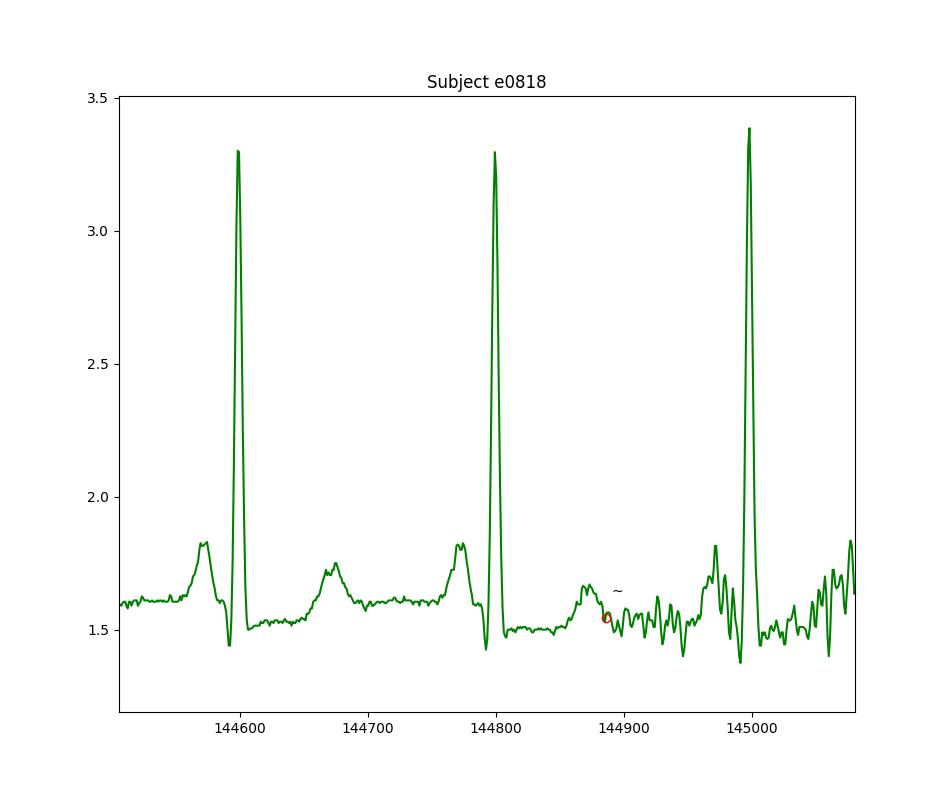

In [76]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,8))
ax_ann = fig.add_subplot(1,1,1)
ax_ann.set_title("Subject {}".format(records_list[idx]))
x_data = np.squeeze(np.array(record_sig[0]),axis=1)
ax_ann.plot(x_data,color="green")

for i,x_location in enumerate(record_ann):
    if record_ann_sym[i] == "N":
        continue
    ax_ann.annotate(record_ann_sym[i], xy=(x_location,x_data[x_location-sampfrom]),
                    xycoords="data", textcoords="offset pixels", xytext=(3,17))

record_ann_x = [x_location-sampfrom-1 for i,x_location in enumerate(record_ann) if record_ann_sym[i]!="N"]
record_ann_v = [x_data[x_location-sampfrom-1] for x_location in record_ann_x]
ax_ann.plot(record_ann_x, record_ann_v, "ro", linewidth=2, fillstyle="none")

fig.show()



### QTDB

In [2]:
# Data Extract From Physionet *.dat

input_path = "../ECG_DATASET/qtdb/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

['sel100', 'sel102', 'sel103', 'sel104', 'sel114', 'sel116', 'sel117', 'sel123', 'sel14046', 'sel14157', 'sel14172', 'sel15814', 'sel16265', 'sel16272', 'sel16273', 'sel16420', 'sel16483', 'sel16539', 'sel16773', 'sel16786', 'sel16795', 'sel17152', 'sel17453', 'sel213', 'sel221', 'sel223', 'sel230', 'sel231', 'sel232', 'sel233', 'sel30', 'sel301', 'sel302', 'sel306', 'sel307', 'sel308', 'sel31', 'sel310', 'sel32', 'sel33', 'sel34', 'sel35', 'sel36', 'sel37', 'sel38', 'sel39', 'sel40', 'sel41', 'sel42', 'sel43', 'sel44', 'sel45', 'sel46', 'sel47', 'sel48', 'sel49', 'sel50', 'sel51', 'sel52', 'sel803', 'sel808', 'sel811', 'sel820', 'sel821', 'sel840', 'sel847', 'sel853', 'sel871', 'sel872', 'sel873', 'sel883', 'sel891', 'sele0104', 'sele0106', 'sele0107', 'sele0110', 'sele0111', 'sele0112', 'sele0114', 'sele0116', 'sele0121', 'sele0122', 'sele0124', 'sele0126', 'sele0129', 'sele0133', 'sele0136', 'sele0166', 'sele0170', 'sele0203', 'sele0210', 'sele0211', 'sele0303', 'sele0405', 'sele040

In [17]:
def extract_from_sbj(idx, sampfrom, sampto, ann_types):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx], ann_types, sampfrom=sampfrom, sampto = sampto).sample)[0:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], ann_types,sampfrom=sampfrom, sampto = sampto).symbol)[0:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], ann_types, as_array=True)

    return record_sig, record_ann, record_ann_sym

In [25]:
idx = 5
ann_types = "pu"
record = wfdb.rdrecord(input_path+records_list[idx])

print("RECORD NUMBER :",records_list[idx])
sampfrom = 0
# sampto = record.__dict__["sig_len"]
sampto = record.__dict__["sig_len"]
print(record.__dict__)
print(sampto, len(record.__dict__["p_signal"]))
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto, ann_types)
# print(record_sig)
# print(record_ann)

print("===========================================================================================")
# print("abnormal position :",[record_ann[x] for x in np.where(np.array(record_ann_sym) != "N")[0]])

from collections import Counter
print(Counter(record_ann_sym))

RECORD NUMBER : 305
{'record_name': '305', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 282341, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['ECG', 'ECG'], 'p_signal': array([[-0.04411765, -0.33333333],
       [-0.03431373, -0.31578947],
       [ 0.01470588, -0.14473684],
       ...,
       [ 0.00490196,  0.03947368],
       [-0.01960784,  0.03070175],
       [-0.04411765,  0.02192982]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['305.dat', '305.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [204.0, 228.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-9, -76], 'checksum': [-15097, -26258], 'block_size': [0, 0]}
282341 282341


FileNotFoundError: [Errno 2] No such file or directory: '../ECG_DATASET/mitbih_stch/305.pu'